In [1]:
import sys

sys.path.append("../")

In [2]:
from src.datasets.registry import get_dataset
from src.datasets.common import BaseDataset
from pathlib import Path
import json
from src.utils import download_and_extract_dataset

In [3]:
DATASET_NAMES = ["CHAOS", "MMWHS"]
DOMAINS = ["CT", "MR"]
DATA_PATH = "../data/"
CHECKPOINT_PATH = "../checkpoints/"
USE_3D = False
TRAINING_EPOCHS = {
    ("CHAOS", "CT"): 1,
}
BATCH_SIZE = 64
SPATIAL_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# Set True to enable debug prints/timers/visualizations)
DEBUG = True

In [4]:
CACHE_MAX_ITEMS = 32  # set the in-memory file cache size per dataset (images and segs)
ENABLE_CACHE = True  # set to False to disable caching entirely

In [5]:
CHECKPOINT_PATH = Path(CHECKPOINT_PATH)
DATA_PATH = Path(DATA_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

if USE_3D:
    encoder_type = "swin_unetr"
else:
    encoder_type = "clipseg"

In [6]:
import torch
from monai import transforms


# Normalization stats (mean, std) per dataset/domain
NORM_STATS = {
    ("MMWHS", "MR"): (186.5875, 258.5917),
    ("MMWHS", "CT"): (-745.0086, 1042.7251),
    ("CHAOS", "MR"): (90.8292, 168.8922),
    ("CHAOS", "CT"): (-478.1732, 476.7163),
}

# Optimized preprocessing: resize early


def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    decode_func = get_decode_func(dataset_name, domain)
    mean_std = NORM_STATS.get((dataset_name, domain))
    mean, std = mean_std if mean_std is not None else (None, None)

    # Image-specific transforms
    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]

    # Resize early to reduce compute
    image_transforms.append(
        transforms.Resize(
            spatial_size=SPATIAL_SIZE,
            size_mode="longest",
            mode="area",
            anti_aliasing=True,
        )
    )

    # Convert to tensor and ensure float32 for stable CPU ops
    image_transforms.extend(
        [
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Augmentations (training only) — run in float32 on CPU
    if is_training:
        image_transforms.extend(
            [
                transforms.RandGaussianNoise(prob=0.15, std=0.05),
                transforms.RandAdjustContrast(prob=0.15, gamma=(0.95, 1.05)),
            ]
        )

    # Normalize (still in float32)
    if mean is not None and std is not None:
        image_transforms.append(
            transforms.NormalizeIntensity(
                subtrahend=float(mean),
                divisor=float(std),
                channel_wise=False,
            )
        )

    # Repeat to 3 channels only at the end (2D only)
    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    image_transform = transforms.Compose(image_transforms)

    # Segmentation transforms
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]
    else:
        seg_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
            transforms.Lambda(
                lambda x: decode_func(x)
            ),  # decode after tensor conversion
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    seg_transform = transforms.Compose(seg_transforms)
    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:

            def decode(labels):
                # Convert intensity values to class indices (keep as float32)
                return labels // 63

        elif domain == "CT":

            def decode(labels):
                return torch.where(labels > 0, 1.0, 0.0)

    elif dataset_name == "MMWHS":

        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:

        def decode(labels):
            return labels

    return decode

In [ ]:
def print_grad_status(model):
    trainable = []
    frozen = []
    for name, p in model.named_parameters():
        if p.requires_grad:
            trainable.append(name)
        else:
            frozen.append(name)
    print(f"\n=== Parameters requiring grad: {len(trainable)} ===")
    for n in trainable:
    print(f"  + {n}")
    print(f"\n=== Parameters frozen (no grad): {len(frozen)}===")
    for n in frozen:
        print(f"  - {n}")

    return trainable, frozen

In [8]:
def flip_grad_status(model):
    for p in model.parameters():
        p.requires_grad_(not p.requires_grad)

In [9]:
# Helpers to snapshot parameters and report unchanged ones after finetuning
import torch


def snapshot_parameters(model):
    """Return a CPU snapshot of all parameter tensors by name."""
    return {name: p.detach().clone().cpu() for name, p in model.named_parameters()}


def print_unchanged_parameters(model, snapshot, only_requires_grad: bool = True):
    """Print all parameter names whose values are identical to the snapshot.

    Args:
        model: The model to compare.
        snapshot: Dict[name -> Tensor] with the pre-finetune parameter values.
        only_requires_grad: If True, only consider parameters with requires_grad=True.
    """
    unchanged = []
    considered = 0
    for name, p in model.named_parameters():
        if only_requires_grad and not p.requires_grad:
            continue
        prev = snapshot.get(name)
        if prev is None:
            continue
        curr = p.detach().cpu()
        considered += 1
        if torch.equal(curr, prev):
            unchanged.append(name)

    print("\n=== Parameters unchanged after finetuning ===")
    for n in unchanged:
        print(f"  - {n}")
    print(f"Total unchanged: {len(unchanged)} of {considered} considered")

Finetuning on CHAOS dataset in CT domain with 2d images 
Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver']
🔄 Loading CLIPSeg weights...
model state keys: 508
checkpoint state keys: 54
CLIPSeg weight load summary: matched=54, missing=454, unexpected=0
Missing keys (454):
  - clip_model.positional_embedding
  - clip_model.text_projection
  - clip_model.logit_scale
  - clip_model.visual.class_embedding
  - clip_model.visual.positional_embedding
  - clip_model.visual.proj
  - clip_model.visual.conv1.weight
  - clip_model.visual.ln_pre.weight
  - clip_model.visual.ln_pre.bias
  - clip_model.visual.transformer.resblocks.0.attn.in_proj_weight
  - clip_model.visual.transformer.resblocks.0.attn.in_proj_bias
  - clip_model.visual.transformer.resblocks.0.attn.out_proj.weight
  - clip_model.visual.transformer.resblocks.0.attn.out_proj.bias
  - clip_model.visual.transformer.resblocks.0.ln_1.weight
  - clip_model.visual.transformer.resblocks.0.ln_1.b

Training:   3%|▎         | 1/31 [00:04<02:08,  4.27s/it, Loss=1.1433]

[timer] batch 0: 2.125s


Training:   6%|▋         | 2/31 [00:07<01:38,  3.40s/it, Loss=1.1377]

[timer] batch 1: 1.771s


Training:  10%|▉         | 3/31 [00:09<01:26,  3.09s/it, Loss=1.1396]

[timer] batch 2: 1.818s


Training:  13%|█▎        | 4/31 [00:12<01:20,  2.99s/it, Loss=1.1294]

[timer] batch 3: 1.822s


Training:  16%|█▌        | 5/31 [00:15<01:15,  2.89s/it, Loss=1.0921]

[timer] batch 4: 1.823s


Training:  19%|█▉        | 6/31 [00:18<01:17,  3.10s/it, Loss=1.0400]

[timer] batch 5: 2.412s


Training:  23%|██▎       | 7/31 [00:22<01:15,  3.17s/it, Loss=0.9836]

[timer] batch 6: 1.883s


Training:  26%|██▌       | 8/31 [00:25<01:12,  3.14s/it, Loss=0.9495]

[timer] batch 7: 2.007s


Training:  29%|██▉       | 9/31 [00:28<01:09,  3.17s/it, Loss=0.9240]

[timer] batch 8: 2.054s


Training:  32%|███▏      | 10/31 [00:32<01:12,  3.47s/it, Loss=0.9158]

[timer] batch 9: 1.987s


Training:  35%|███▌      | 11/31 [00:43<01:53,  5.65s/it, Loss=0.9050]

[timer] batch 10: 9.505s


Training:  39%|███▊      | 12/31 [01:02<03:06,  9.84s/it, Loss=0.8800]

[timer] batch 11: 12.412s


Training:  42%|████▏     | 13/31 [01:23<03:56, 13.12s/it, Loss=0.8630]

[timer] batch 12: 11.929s


Training:  45%|████▌     | 14/31 [01:31<03:18, 11.67s/it, Loss=0.8503]

[timer] batch 13: 1.759s


Training:  48%|████▊     | 15/31 [01:34<02:24,  9.03s/it, Loss=0.8348]

[timer] batch 14: 1.830s


Training:  52%|█████▏    | 16/31 [01:37<01:47,  7.18s/it, Loss=0.8226]

[timer] batch 15: 1.837s


Training:  55%|█████▍    | 17/31 [01:40<01:22,  5.90s/it, Loss=0.8340]

[timer] batch 16: 1.915s


Training:  58%|█████▊    | 18/31 [01:43<01:04,  4.99s/it, Loss=0.8480]

[timer] batch 17: 1.947s


Training:  61%|██████▏   | 19/31 [01:45<00:51,  4.32s/it, Loss=0.8465]

[timer] batch 18: 1.744s


Training:  65%|██████▍   | 20/31 [01:48<00:41,  3.79s/it, Loss=0.8151]

[timer] batch 19: 1.751s


Training:  68%|██████▊   | 21/31 [01:51<00:34,  3.47s/it, Loss=0.8063]

[timer] batch 20: 1.845s


Training:  71%|███████   | 22/31 [01:53<00:28,  3.21s/it, Loss=0.8121]

[timer] batch 21: 1.819s


Training:  74%|███████▍  | 23/31 [01:56<00:25,  3.14s/it, Loss=0.8132]

[timer] batch 22: 1.889s


Training:  77%|███████▋  | 24/31 [01:59<00:21,  3.06s/it, Loss=0.8071]

[timer] batch 23: 1.870s


Training:  81%|████████  | 25/31 [02:02<00:18,  3.10s/it, Loss=0.7884]

[timer] batch 24: 2.011s


Training:  84%|████████▍ | 26/31 [02:06<00:15,  3.14s/it, Loss=0.7906]

[timer] batch 25: 1.918s


Training:  87%|████████▋ | 27/31 [02:08<00:12,  3.02s/it, Loss=0.7826]

[timer] batch 26: 1.847s


Training:  90%|█████████ | 28/31 [02:11<00:08,  2.98s/it, Loss=0.8218]

[timer] batch 27: 1.895s


Training:  94%|█████████▎| 29/31 [02:15<00:06,  3.06s/it, Loss=0.8654]

[timer] batch 28: 2.267s


Training:  97%|█████████▋| 30/31 [02:18<00:03,  3.24s/it, Loss=0.8768]

[timer] batch 29: 2.562s


Training: 100%|██████████| 31/31 [02:22<00:00,  4.59s/it, Loss=0.8418]


[timer] batch 30: 2.519s
Epoch 1 - Train Loss: 0.8909
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+1.144306e+00 (before=8.586586e+00, after=9.730892e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+9.947181e-03 (before=1.183554e+00, after=1.193501e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+1.061639e+00 (before=8.633878e+00, after=9.695517e+00)
   Grad non-zero in batches: 31/31 (100.0%)
   Labels seen this epoch: [0, 1]


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

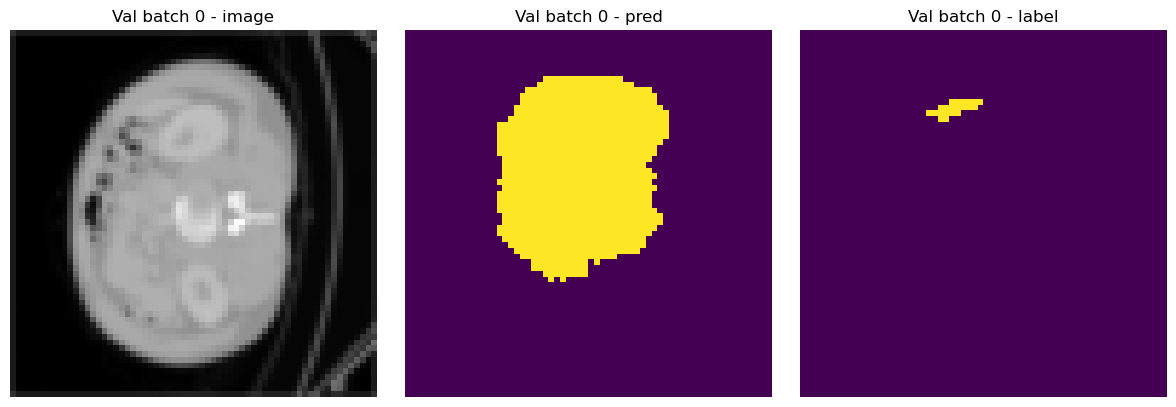

Validating:  14%|█▍        | 1/7 [00:02<00:17,  2.91s/it]


Epoch 1 - Val Loss: 0.7672
   New best Val Loss: 0.7672

✅ Training completed!

=== Parameters unchanged after finetuning ===
  - encoder.clipseg.clip_model.visual.proj
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.in_proj_weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.in_proj_bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.out_proj.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.out_proj.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.ln_1.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.ln_1.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_fc.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_fc.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_proj.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_proj.bias
  - encoder.clipseg.clip_model.visual

In [ ]:
# Finetuning loop

for (dataset_name, domain), epochs in TRAINING_EPOCHS.items():
    download_and_extract_dataset(dataset_name, DATA_PATH)

    image_transform, seg_transform = get_preprocessing(
        dataset_name, domain, is_training=True
    )

    print(
        f"Finetuning on {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images "
    )
    dataset: BaseDataset = get_dataset(
        dataset_name=dataset_name,
        domain=domain,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        num_workers=0,
        slice_2d=not USE_3D,
        # new cache knobs
        cache_max_items=CACHE_MAX_ITEMS,
        enable_cache=ENABLE_CACHE,
    )

    #  Ensure the dataset is loaded correctly
    if not isinstance(dataset, BaseDataset):
        raise TypeError(
            f"Expected dataset to be an instance of BaseDataset, got {type(dataset)}"
        )

    model = dataset.get_model(
        encoder_type=encoder_type,
    )

    # Train Only Segmentation Head
    # pass

    # Train Visual Encoder + Segmentation head
    # model.unfreeze()
    # model.freeze_text_encoder()

    # Train Only Visual Encoder
    for p in model.encoder.clipseg.model.parameters():
        p.requires_grad_(not p.requires_grad)
    model.freeze_text_encoder()

    # Print grad status before finetuning (after final freeze mask)
    print_grad_status(model)

    # Snapshot parameters before finetuning (after setting requires_grad correctly)
    before_snapshot = snapshot_parameters(model)

    history = model.finetune(
        epochs=1,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        val_max_batches=1,
        fast_val_metrics=True,
        debug=DEBUG,
    )

    # Print parameters that didn't change after finetuning (only those requiring grad)
    print_unchanged_parameters(model, before_snapshot, only_requires_grad=True)